Additinal reading:

https://answers.opencv.org/question/213227/stereo-sgbm-algorithm/

....

Porting cpp implementation to python.

With the following input: `input0.png input1.png -c kitti1` I get this:
```
cameraMatrix: {
 +721.537700	   +0.000000	 +609.559300
   +0.000000	 +721.537700	 +172.854000
   +0.000000	   +0.000000	   +1.000000
}

F: {
   +0.000004	   +0.001871	   -0.324283
   -0.001874	   -0.000004	   +1.169413
   +0.320299	   -1.166596	   +1.000000
}

epipole1: x=623.681 y=172.094  

epipole2: x=623.681 y=172.094
```

Let's first achieve that...

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

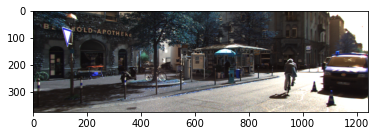

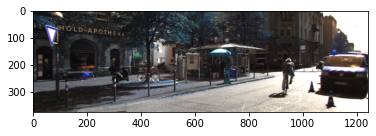

In [2]:
src_dir = '../test-images/2011_09_26_drive_0005_sync-83-84'
filenames = ['0000000083.png', '0000000084.png']
image_files = [f'{src_dir}/{f}' for f in filenames]
img1, img2 = [cv.imread(f) for f in image_files]

plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

In [3]:
# just take it for granted 
F = np.array([
   [+0.000002,       -0.000929,       +0.168397],
   [+0.000930,       -0.000002,       -0.612318],
   [-0.171481,       +0.612492,       +1.000000]
])
# imag size is tranposed (cuz images are normally rotated sideways)
img_size = img1.shape[1::-1]

In [4]:
pr = cv.polarrect_PolarRectification.create(F, img_size)
pr.compute()

In [5]:
def remap(src, map):
    return cv.remap(src, map, None, cv.INTER_LINEAR,\
        borderMode=cv.BORDER_TRANSPARENT)

polar1 = remap(img1, pr.forward_map(0))
polar2 = remap(img2, pr.forward_map(1))

cv.imwrite('polar1.png', polar1)
cv.imwrite('polar2.png', polar2)

True

In [ ]:
#TODO: 
# - calculate F, epipoles, etc.
# - handle cases where left and right images are swapped
# - compute and apply derotation homography. 

In [24]:
# downscale images for faster processing
imgL = polar1
imgR = polar2

# disparity range is tuned for 'aloe' image pair
window_size = 3
min_disp = 16
num_disp = 112-min_disp
stereo = cv.StereoSGBM_create(minDisparity = min_disp,
    numDisparities = num_disp,
    blockSize = 1,
    P1 = 8*3*window_size**2,
    P2 = 32*3*window_size**2,
    disp12MaxDiff = 1,
    uniquenessRatio = 10,
    speckleWindowSize = 50,
    speckleRange = 16
)

print('computing disparity...')
disp = stereo.compute(imgL, imgR).astype(np.float32)

computing disparity...


In [25]:
norm_disp = (disp-min_disp)/num_disp
pd = remap(norm_disp, pr.get_reverse_map(0))
left = remap(polar1, pr.get_reverse_map(0))
cv.imwrite('left.png', left)
cv.imwrite('polard_disp.png', norm_disp)
cv.imwrite('disp.png', pd)

True

In [47]:
cv.triangulatePoints?

Docstring:
triangulatePoints(projMatr1, projMatr2, projPoints1, projPoints2[, points4D]) -> points4D
.   @brief This function reconstructs 3-dimensional points (in homogeneous coordinates) by using
.   their observations with a stereo camera.
.   
.   @param projMatr1 3x4 projection matrix of the first camera, i.e. this matrix projects 3D points
.   given in the world's coordinate system into the first image.
.   @param projMatr2 3x4 projection matrix of the second camera, i.e. this matrix projects 3D points
.   given in the world's coordinate system into the second image.
.   @param projPoints1 2xN array of feature points in the first image. In the case of the c++ version,
.   it can be also a vector of feature points or two-channel matrix of size 1xN or Nx1.
.   @param projPoints2 2xN array of corresponding points in the second image. In the case of the c++
.   version, it can be also a vector of feature points or two-channel matrix of size 1xN or Nx1.
.   @param points4D 4xN array o

In [48]:
cv.correctMatches?

Docstring:
correctMatches(F, points1, points2[, newPoints1[, newPoints2]]) -> newPoints1, newPoints2
.   @brief Refines coordinates of corresponding points.
.   
.   @param F 3x3 fundamental matrix.
.   @param points1 1xN array containing the first set of points.
.   @param points2 1xN array containing the second set of points.
.   @param newPoints1 The optimized points1.
.   @param newPoints2 The optimized points2.
.   
.   The function implements the Optimal Triangulation Method (see Multiple View Geometry for details).
.   For each given point correspondence points1[i] \<-\> points2[i], and a fundamental matrix F, it
.   computes the corrected correspondences newPoints1[i] \<-\> newPoints2[i] that minimize the geometric
.   error \f$d(points1[i], newPoints1[i])^2 + d(points2[i],newPoints2[i])^2\f$ (where \f$d(a,b)\f$ is the
.   geometric distance between points \f$a\f$ and \f$b\f$ ) subject to the epipolar constraint
.   \f$newPoints2^T * F * newPoints1 = 0\f$ .
Type:      builtin_f

so after I get matches from polar rectification stuff, id do

1. `cv.correctMatches` to remove gaussian error from matches with optimal method (6-degree polinomial)
2. `cv.triangulatePoints` to map correct matches to 3D points (in homogenious coords...) 